In [1]:
#| default_exp mesh

In [2]:
#| export

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import igl

from scipy import spatial

import copy

In [3]:
#| export

import jax
import jax.numpy as jnp

In [4]:
#| export

from jaxtyping import Float, Int, Bool, PyTree 
from typing import Any, Iterable, NamedTuple
from pathlib import Path
from enum import IntEnum

import dataclasses

import functools

In [5]:
#| export

from triangulax import trigonometry as trig

In [6]:
#| hide

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_log_compiles', False) # use this to log JAX JIT compilations.

In [7]:
#| hide

import jaxtyping


In [ ]:
#| hide

# %load_ext jaxtyping 
# %jaxtyping.typechecker beartype.beartype

# enables type checking. does not work for some cells (vmapping and loading/saving)

## JAX-compatible data structure triangulations

First, we need to create a suitable data structure to describe cell arrays. We will represent cell tilings by 2D Voronoi tessellations and variants thereof (like power diagrams). Cells are denoted by Latin indices $i,j,k, \dots$. Voronoi tessellations are dual to Delaunay triangulations (each Voronoi vertex is a Delaunay triangle). This means that we can represent the cell network as a 2D triangulation with vertices $V$ and faces $F$. Each face is an (ordered) triple of vertices $(i,j,k)$. Vertex positions are denoted $\mathbf{v}_i$.

We will first consider the case where the number of vertices does not change. Cells can, however, rearrange (T1-transitions/edge flips in the triangulation). Such flips also conserve the number of faces and edges. In addition to the vertices and faces, we will need to store various _attributes_ for vertices, faces, and edges (for example, the edge lengths, or the Voronoi position of a face).

### Coding style notes

Throughout, we will (attempt to) provide a type signature for all functions. To do so for array-based functions, we use  [jaxtyping](https://docs.kidger.site/jaxtyping).

### JAX

The aim is to create a triangulation datastructure compatible with the JAX library for automatic differentiation and numerical computing. In practice, this means that we use `jnp` (=`jax.numpy`) instead of `numpy`, and make sure our code follows JAX's functional programming paradigm (see [JAX- the sharp bits](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html)). There is also some extra legwork to register any new classes with JAX.

### Triangular mesh datastructure

The simplest way to represent a cell tiling is by its _dual_ triangular mesh (one triangulation vertex per cell). Triangles will be denoted as _faces_. We thus represent a cell tiling by:

1. A set of vertices, i.e., a $(N_V, 2)$ dimensional array datatype `float`.
2. A set of faces, a $(N_F, 3)$ dimensional array of datatype `int`. Each row is a triple of vertex indices that form a face.
3. A set of face positions, a $(N_F, 2)$ dimensional array of datatype `float`. An entry is the position of the tesselation vertex dual to the triangulation face.

To read and write, we use the `.obj`-file format. We will also make heavy use of the `igl` geometry processing library. 
We start by defining a minimal `TriMesh` class for our cell-tiling objects. This class is mainly a "holder" class for loading, saving, visualizing, etc meshes, and not to be used for numerical computation. We come to that below.

Further below, we will also add optional attributes for faces, vertices, and edges. Each attribute is a dictionary with keys (from an `Enum` of possibilities) and values, which are `numpy` vectors whose $n$th entry corresponds to vertex/face/edge $n$. For this reason, vertices/faces/edges are _ordered_.

In [ ]:
#| export

@dataclasses.dataclass(init=True, repr=False, eq=False, frozen=False, slots=False)
class TriMesh:
    """
    Simple class for reading, holding, transforming, and saving triangular meshes.
    
    A TriMesh comprises vertices and faces, describing a surface in 2d or 3d. 
    In addition, there can be a 2d/3d position for every face (think Voronoi dual of the triangulation).
    
    Vertices and faces are jnp.arrays. Each face is a triple of vertex indices.
    Vertices and faces are ordered - this is essential so that we know which attribute
    vector entry goes to which vector/edge/face. Faces in a face are assumed to be in counter-clockwise order.

    Meshes are read and written in the .obj format (https://en.wikipedia.org/wiki/Wavefront_.obj_file).
    To store _face_positions_, we abuse the `vn` (vertex normal) entry of an .obj file. Face
    positions will be written in order corresponding to faces.
    When reading from an .obj file, edges are recomputed from faces and initialized in alpha-numerical ordering.
    An .obj file expects 3d positions; the z-position is ignored when reading and set to 0 when writing for 2d meshes.

    **Attributes**

    dim : int = 2
    
    vertices : Float[jax.Array, "n_vertices dim"]

    faces : Int[jax.Array, "n_faces 3"]

    face_positions : Float[jax.Array, "n_faces dim"]

    **Property methods (use like attributes)**

    n_vertices : int

    has_inf_vertex : bool

    **Static methods**
    
    read_obj : str -> TriMesh

    **Methods**

    write_obj : str -> None
        
    """
    vertices : Float[jax.Array, "n_vertices dim"]
    faces : Int[jax.Array, "n_faces 3"]
    face_positions : Float[jax.Array, "n_faces dim"] | None = None

    def set_voronoi(self):
        """Set face positions to the Voronoi dual of the faces is computed."""
        self.face_positions = jax.vmap(trig.get_circumcenter)(*[self.vertices[fcs] for fcs in self.faces.T])
        
    @staticmethod  
    def read_obj(filename: str | Path, read_face_positions: bool = False, dim: int = 2) -> "TriMesh":
        """
        Read vertices, texture vertices, normals, and faces from an obj file.

        Indices of returned faces start at 0. See https://en.wikipedia.org/wiki/Wavefront_.obj_file.
        Intended for .obj files containing a single object only.

        Parameters
        ----------
        filename : str
            filename
        read_face_positions : bool
            If True, use the vertex normal entries `vn` in the .obj file
            as face positions. This is an abuse of the .obj file format
            so only use this for files written by this code.
        dim : int
            Dimension - can be 2 or 3. If 2, the z-coordinate is ignored.
        
        Returns
        -------
        mesh: TriMesh
        """
        vertices, _, normals, faces, _, _ = igl.readOBJ(filename)
        if read_face_positions:
            return TriMesh(jnp.array(vertices[:,:dim]), jnp.array(faces), face_positions=jnp.array(normals[:,:dim]))
        mesh = TriMesh(jnp.array(vertices[:,:dim]), jnp.array(faces), face_positions=None)
        mesh.set_voronoi()
        return mesh
        
    def write_obj(self, filename: str | Path, save_face_positions: bool=True) -> None:
        """
        Write mesh to .obj format.

        Parameters
        ----------
        filename : str
            filename to save to
        save_face_positions : bool
            If true, face positions are written to the `vn` line of .obj files.
            
        Returns
        -------
        None
        """
        if self.dim == 2:
            vlines = ["v {} {} 0\n".format(*v) for v in self.vertices]
            vnlines = ["vn {} {} 0\n".format(*vn) for vn in self.face_positions]
        elif self.dim == 3:
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            vnlines = ["vn {} {}\n".format(*vn) for vn in self.face_positions]
        flines = ["f {} {} {}\n".format(*[int(v+1) for v in fc]) for fc in self.faces]

        with open(filename, 'w') as f:
            f.writelines(vlines)
            if save_face_positions:
                f.writelines(vnlines)               
            f.writelines(flines)
        return None

    @property
    def has_inf_vertex(self) -> bool:
        return jnp.isinf(self.vertices).any()

    @property
    def n_vertices(self) -> int:
        return self.vertices.shape[0]

    @property
    def dim(self) -> int:
        return self.vertices.shape[-1]



In [13]:
# test reading a mesh
mesh = TriMesh.read_obj("test_meshes/disk.obj")

  o flat_tri_ecmc


In [14]:
# test computing the circumcenter of each face. should be equidistant to all vertex points

dists = jnp.stack([jnp.linalg.norm(mesh.vertices[mesh.faces[:,i]]-mesh.face_positions, axis=1) for i in [0,1,2]], axis=1)

jnp.allclose(dists[:,0], dists[:,1]) and jnp.allclose(dists[:,1], dists[:,2])

Array(True, dtype=bool)

In [15]:
# test writing face positions to vn entries

mesh = TriMesh.read_obj("test_meshes/disk.obj")
filename = "test_meshes/disk_write_test.obj"
mesh.write_obj(filename, save_face_positions=True)
mesh = TriMesh.read_obj(filename, read_face_positions=True)

  o flat_tri_ecmc


### Creating meshes and plotting

Some functions to create meshes based on the Delaunay triangulation of a point set.

1. Poisson (vertices placed uniformly at random) in disk or box
2. Ginibre (vertices placed at uniform with self-repulsion)
3. Triangular lattice

Some functions for plotting meshes:

1. Plot triangulation with vertex and face labels (for debugging)
2. Plot cell tesselation

In [16]:
#| export

def generate_ginibre_points(n_vertices: int) -> Float[jax.Array, "n_vertices 2"]:
    """Sample n_vertices points from the Ginibre ensemble. Points are scaled to unit disk."""
    M = np.random.normal(size=(n_vertices, n_vertices)) + 1j*np.random.normal(size=(n_vertices, n_vertices))
    vals = np.linalg.eigvals(M)
    pos = np.stack([vals.real, vals.imag], axis=-1)
    # rescale to unit disk
    pos /= np.linalg.norm(pos, axis=1).mean()
    return jnp.array(pos)

def generate_poisson_points(n_vertices: int, limit_x: float = 1, limit_y: float = 1
                           ) -> Float[jax.Array, "n_vertices 2"]:
    """Sample n_vertices points from the Poisson ensemble in rectangle
    [-limit_x/2, limit_x/2] * [-limit_y/2, limit_y/2]."""
    pos = np.stack([np.random.uniform(size=n_vertices, low=-limit_x/2, high=limit_x/2),
                    np.random.uniform(size=n_vertices, low=-limit_y/2, high=limit_y/2)])
    return jnp.array(pos)

def generate_triangular_lattice(nx: int, ny: int) -> Float[jax.Array, "nx*ny 2"]:
    """Get points for rectangular patch of triangular lattice with nx, ny points."""
    y = np.arange(0, ny)*np.sqrt(3)/2
    x = np.arange(nx).astype(float)
    X, Y = np.meshgrid(x, y)
    X -= X.mean()+1/2
    Y -=Y.mean()
    X = (X.T+(np.arange(ny)%2)/2).T
    pts = np.stack([X, Y]).reshape((2,nx*ny))    
    return jnp.array(pts.T)

(np.float64(-1.6315276371405518),
 np.float64(1.6191872290800107),
 np.float64(-1.4880190145409438),
 np.float64(1.7089872695623352))

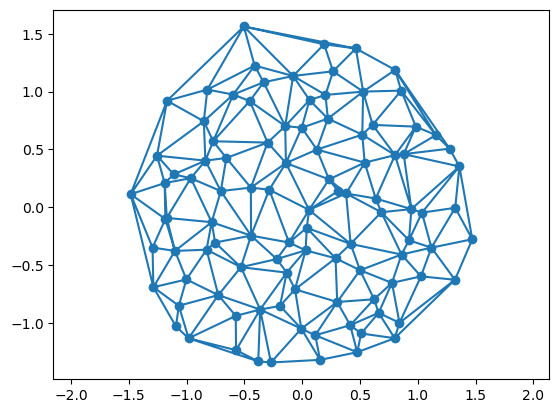

In [17]:
#points = generate_triangular_lattice(10, 10)

points = generate_ginibre_points(100)
mesh = TriMesh(vertices=points, faces=jnp.array(spatial.Delaunay(points).simplices))

plt.triplot(*points.T, mesh.faces)

plt.scatter(*points.T)
plt.axis("equal")

### Elementary book-keeping using list-of-triangles data structure

In [18]:
#| export

# find the vertices and faces which are adjacent to a given vertex, in the correct counter-clockwise order.

def get_adjacent_vertex_indices(faces: Int[jax.Array, "n_faces 3"],
                                n_vertices: int) -> list[Int[jax.Array, " n_neighbors"]]:
    """For each vertex, get the indices of the adjacent vertices in correct order.
    For boundary vertices, this list contains the vertex itself."""
    vf, ni = igl.vertex_triangle_adjacency(mesh.faces, n=n_vertices)
    adjacent_faces = [vf[a:b] for a, b in zip(ni[:-1], jnp.roll(ni, -1)[:-1])]
    adjacent_vertices = [jnp.array(igl.boundary_loop(faces[fcs])) for fcs in adjacent_faces]
    return adjacent_vertices

In [19]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")

neighbors = get_adjacent_vertex_indices(mesh.faces, n_vertices=mesh.vertices.shape[0])

  o flat_tri_ecmc


## Half-edge meshes

For simulation and geometry processing, we need a different representation of the adjacency information than the list of triangle (for example, to compute the area of a cell). Typically, this is achieved by a [half-edge mesh](https://www.jerryyin.info/geometry-processing-algorithms/half-edge/) (HE) data structure. We represent the HE data structure by 3 sets of integer index arrays:

1. Vertices: 1 $(N_V,)$ matrix, whose entry for vertex $i$ is an arbitrary HE incident on $i$
2. Edges: 6 $(2N_E,)$ matrices, [`origin`, `dest`, `nxt`, `prv`, `twin`, `face`] for each half-edge. `face` can be `np.nan` for boundary vertices.
3. Faces, 1 $(N_F, 1)$ matrix, whose entry for face $i$ is an arbitrary HE in $i$. (Not to be confused with the $(N_F, 3)$ matrix of _vertex IDs_ used previously).

Additionally, there are two float arrays for vertex and face positions, as previously. However, we split _combinatorial_ and _geometric_ information - a `HeMesh` class for the combinatorics, and a couple of regular arrays for the vertex positions, face positions, and vertex/half-edge/face attributes. The latter are packaged into a `GeomMesh` class. Together, the pair `(GeomMesh, HeMesh)` describes a mesh (like vertices/faces pair). A named tuple `Mesh` comines the two.

The first task is to create a helper function to plot mesh connectivity, and to create the half-edge connectivity matrices from the more conventional list-of-triangles format. The latter is somewhat involved.

In [20]:
#| export

def label_plot(vertices: Float[jax.Array, "n_vertices 2"],
               faces: Int[jax.Array, "n_faces 3"],
               hemesh: None | PyTree=None,
               vertex_labels: bool = True, face_labels: bool=True,
               ax: None | mpl.axes.Axes=None,
               fontsize: int|None = None) -> None:
    """For debugging purposes. Plot triangular mesh with face/vertex labels in black/blue.
    If hemesh is not None, the connectivity info from it is used to plot the half-edge labels."""
    ax = plt.gca() if ax is None else ax
    if vertex_labels:
        for iv, v in enumerate(vertices):
            ax.text(*(v+np.array([0,.025])), str(iv),
                    color="tab:blue", ha="center", fontsize=fontsize)
    if face_labels:
        for ifc, fc in enumerate(faces):
            centroid = np.mean([vertices[iv] for iv in fc], axis=0)
            ax.text(*centroid, str(ifc), color="k", fontsize=fontsize, ha="center",)
    if hemesh is not None:
        edge_center = (vertices[hemesh.dest] + vertices[hemesh.orig])/2
        for ie in np.where(hemesh.is_unique)[0]:
            ax.text(*edge_center[ie], f"{ie}/{hemesh.twin[ie]}",
            color="tab:orange", ha="center", fontsize=fontsize)
            
    return None

  o flat_tri_ecmc


(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

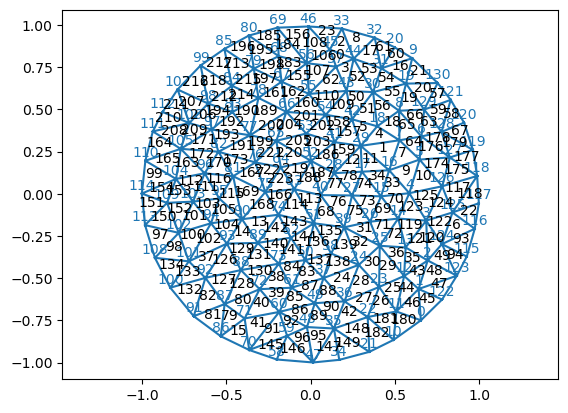

In [21]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")

plt.triplot(*mesh.vertices.T, mesh.faces)
label_plot(mesh.vertices, mesh.faces, fontsize=10)
plt.axis("equal")

In [22]:
#| export

def get_half_edge_arrays(n_vertices: int, faces: Int[jax.Array, "n_faces 3"]) -> list[Int[jax.Array, " n"]]:
    """
    Get half-edge data structure arrays from faces.

    Returns: incident, orig, dest, twin, nxt, prv, heface, face_incident
    """
    # form all unique edges, ordered lexicographically
    edges = np.array(sorted([sorted(x) for x in igl.edges(faces)]))
    half_edges = np.vstack([edges, edges[:,::-1]])

    # initialize the connectivity arrays
    orig, dest = (half_edges[:,0], half_edges[:, 1])
    twin = np.hstack([np.arange(edges.shape[0])+edges.shape[0], np.arange(edges.shape[0])])

    # iterate over faces to get face, prv, and nxt for each half-edge
    nxt, prv, heface = (np.ones_like(orig), np.ones_like(orig), -1*np.ones_like(orig),)
    for ifc, fc in enumerate(faces):
        for v_prv, v, v_nxt in zip(np.roll(fc, 1), fc, np.roll(fc, -1)):
            heface[(orig==v) & (dest==v_nxt)] = ifc
            nxt[(orig==v_prv) & (dest==v)] = np.where((orig==v) & (dest==v_nxt))[0][0]
            prv[(orig==v) & (dest==v_nxt)] = np.where((orig==v_prv) & (dest==v))[0][0]
    
    # finally, prv and nxt for the boundary hes
    for loop in igl.boundary_loop_all(faces):
        for v_nxt, v, v_prv in zip(np.roll(loop, 1), loop, np.roll(loop, -1)):
            nxt[(orig==v_prv) & (dest==v)] = np.where((orig==v) & (dest==v_nxt))[0][0]
            prv[(orig==v) & (dest==v_nxt)] = np.where((orig==v_prv) & (dest==v))[0][0]

    # get an incident half-edge for each vertex and face 
    incident = np.array([np.argmax(orig==v) for v in range(n_vertices)])
    face_incident = np.array([np.argmax(heface==ifc) for ifc, _ in enumerate(faces)])            

    return [jnp.array(arr) for arr in [incident, orig, dest, twin, nxt, prv, heface, face_incident]]

### JAX compatibility

We want to be compatible with JAX. For this reason, we

1. Always use `jnp` = `jax.numpy` instead of `np`
2. Instead of in-place array modifications, use JAX's `x = x.at[idx].set(y)` syntax
3. _Avoid_ any in-place modifications in the `HeMesh` and `GeomHeMesh` data structures
4. _Register_ our (data)classes with JAX, so JAX knows how to handle them during gradient-computation and just-in-time compilation. See [here](https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html#using-jax-jit-with-class-methods) and [here](https://docs.jax.dev/en/latest/custom_pytrees.html). This involves declaring which parts are mutable and which parts are permanent. 

Lateron, for simulations, we use the `equinox` library, which adds a few useful tools to JAX. (A neural-network library like `flax` is probably overkill).

#### PyTrees

JAX supports not only arrays as inputs/outputs/intermediate variables, but also [pytrees](https://docs.jax.dev/en/latest/pytrees.html). Pytrees are nested structures (dicts, lists-of-lists, etc) whose leaves are "elementary" objects like arrays. Fortunately, our `HeMesh` class is already a lot like a pytree - it is a collection of arrays. For JAX to understand this, we need to register our `HeMesh` class as a [custom pytree node](https://docs.jax.dev/en/latest/custom_pytrees.html#pytrees-custom-pytree-nodes). We register our dataclasses using `jax.tree_util.register_dataclass`.

Sidenote: Neural networks, in libraries like Flax or Equinox, are basically very similar. They are dataclass-like classes which hold all the arrays associated with a NN (the different weights, and maybe some parameters) with class methods like `__call__` specifying the forward pass through the NN.
Equinox automatically registers your NN as a pytree by inheriting from the `equinox.Module` class.

#### [Control flow](https://docs.jax.dev/en/latest/control-flow.html)

For just-in-time compilation, JAX distinguishes two types of variables: dynamic and static. Control flow cannot depend on the _value_ of dynamic variables, only on their shape.

Upshots:
1. replace `if` with `jax.lax.cond` / `jnp.where` (full autodiff compatible), and `while` with `jax.lax.while_loop` (forward autodiff only).
2. mark variables which are not going to change during simulation as static.

In [23]:
#| export

@jax.tree_util.register_dataclass
@dataclasses.dataclass(repr=False, eq=False, frozen=True)
class HeMesh:
    """
    Half-edge mesh data structure for triangular meshes.

    A half-edge mesh is described by a set of half-edges and several
    arrays that specify their connectivity (see markup explanation above).
    This class serves as a container for multiple arrays.
    For future compatibility with JAX, after initialization, do not
    modify these arrays in-place; always return a new HeMesh object.
    The mesh vertices may live in whatever dimension - this
    does not affect the connectivity bookkeeping.

    Half-edge meshes are initialized from a list of triangles and a 
    number of vertices, and can return the original triangles (e.g., to save as a .obj).

    All information and methods are purely "combinatorial". The
    HeMesh class does _not_ contain the vertex or face positions.
    These are saved in the GeomHeMesh class that combines
    a HeMesh (combinatorics) with a couple of other arrays (geometry).

    ---Conventions---
    
    For vertices, the `incident` half-edge points _away_ from the vertex.

    To describe the mesh boundary, there are two options:
        1. Initialize from a triangulation with a boundary. Half-edges without
        a face (boundary) are assigned heface=-1.
        2. Initialize from a triangulation without boundary, where certain vertices
         are "at infinity". They should have coordinates [np.inf, np.inf].
         Each infinity vertex corresponds to one boundary. For a single
         boundary, the vertex at infinity is, by convention, the final one.

    Starting from a set of triangles, the half-edges are initialized as follows:
    The 1st N_edges half-edges are (origin_vertex, destination_vertex), in lexicographic order, with 
    origin_vertex < destination_vertex. The 2nd N_edges are their twins, in the same order.

    **Attributes**
    
    incident : Int[jax.Array, "n_vertices"]

    orig : Int[jax.Array, "n_hes"]

    dest : Int[jax.Array, "n_hes"]

    nxt : Int[jax.Array, "n_hes"]

    prv : Int[jax.Array, "n_hes"]

    twin : Int[jax.Array, "n_hes"]

    heface : Int[jax.Array, "n_hes"]

    face_incident : Int[jax.Array, "n_faces"]

    inf_vertices : tuple[Int]

    **Property methods (use like attributes)**

    n_vertices : int

    n_hes : int

    n_faces : int

    n_items : tuple[int, int, int]

    faces : Int[jax.Array, "n_faces 3"]

    has_inf_vertex : bool

    is_inf_face : Bool[jax.Array, "n_faces"]

    is_unique : Bool[jax.Array, "n_hes"]

    is_inf_he : Bool[jax.Array, "n_hes"]

    is_bdry_he : Bool[jax.Array, "n_hes"]

    is_bdry_edge : Bool[jax.Array, "n_hes"]

    is_bdry : Bool[jax.Array, "n_vertices"]

    **Static methods**

    from_triangles : tuple[int, Int[jax.Array, "n_faces 3"], Int[jax.Array, "n_boundaries"] -> HeMesh

    **Class methods**

    iterate_around_vertex : int -> Int[jax.Array, "n_neighbors"]

    save : str -> None:

    **Static methods**
    
    load : str -> HeMesh

    """
    
    incident : Int[jax.Array, "*batch n_vertices"]
    orig : Int[jax.Array, "*batch n_hes"]
    dest : Int[jax.Array, "*batch n_hes"] 
    twin : Int[jax.Array, "*batch n_hes"] 
    nxt : Int[jax.Array, "*batch n_hes"] 
    prv : Int[jax.Array, "*batch n_hes"]
    heface : Int[jax.Array, "*batch n_hes"]
    face_incident : Int[jax.Array, "*batch n_faces"]
    inf_vertices : tuple[()] | tuple[int] = dataclasses.field(default=(), metadata=dict(static=True))

    # convert from and to a list of triangles

    @staticmethod
    def from_triangles(n_vertices: int, faces: Int[jax.Array, "n_faces 3"],
                       inf_vertices: tuple[()] | tuple[int] =()):
        # get HE data arrays
        incident, orig, dest, twin, nxt, prv, heface, face_incident = get_half_edge_arrays(n_vertices, faces)
        return HeMesh(incident, orig, dest, twin, nxt, prv, heface, face_incident, inf_vertices)

    @property
    def faces(self) -> Int[jax.Array, "n_faces 3"]:
        """Get faces (list of vertices per face)."""
        return jnp.stack([self.orig[self.face_incident],
                          self.dest[self.face_incident],
                          self.dest[self.nxt[self.face_incident]]], axis=1)
    
    # mesh size info

    @property
    def n_vertices(self) -> int:
        return self.incident.shape[0]
    
    @property
    def n_hes(self) -> int:
        return self.orig.shape[0]

    @property
    def n_faces(self) -> int:
        return self.face_incident.shape[0]

    @property
    def n_items(self) -> tuple[int, int, int]:
        return (self.n_vertices, self.n_hes, self.n_faces)
    
    @property
    def is_unique(self) -> Bool[jax.Array, "n_hes"]:
        """Get an (arbitrary) set of unique half-edges (every edge is represented once)."""
        return self.orig < self.dest

    def __repr__(self) -> str:
        return "HeMesh(N_V={}, N_HE={}, N_F={})".format(*self.n_items)
    
    # boundary info - implemented as class methods to hide "implementation detail" of infinity vertices
    
    @property
    def has_inf_vertex(self) -> bool:
        return len(self.inf_vertices)>0

    @property
    def is_inf_face(self) -> Bool[jax.Array, "n_faces"]:
        """True if face is fictitious/connected to an infinity vertex."""
        return jnp.isin(self.faces, jnp.array(self.inf_vertices)).any(axis=1)

    @property
    def is_inf_he(self) -> Bool[jax.Array, "n_hes"]:
        """True if half-edge is fictitious/connected to an infinity vertex."""
        return jnp.isin(self.orig, jnp.array(self.inf_vertices)) | jnp.isin(self.dest, jnp.array(self.inf_vertices))
    
    @property
    def is_bdry_he(self) -> Bool[jax.Array, "n_hes"]:
        return jax.lax.select(self.has_inf_vertex, jnp.isin(self.dest[self.nxt], jnp.array(self.inf_vertices)), self.heface == -1)

    @property
    def is_bdry_edge(self) -> Bool[jax.Array, "n_hes"]:
        return self.is_bdry_he | self.is_bdry_he[self.twin]
    
    @property
    def is_bdry(self) -> Bool[jax.Array, "n_vertices"]:
        v_field = jnp.zeros(self.n_vertices)
        return v_field.at[self.dest].add(1*self.is_bdry_he) > 0

    # mesh traversal
    
    def iterate_around_vertex(self, v: int) -> Int[jax.Array, " n_neighbors"]:
        """Get list of half-edges going out of a vertex."""
        polygon_edges = [self.incident[v]]
        while True: # this while loop is challenging to rewrite using jax.lax since the output shape is not known!
            next_edge = self.twin[self.prv[polygon_edges[-1]]]
            if next_edge == polygon_edges[0]:
                break
            polygon_edges.append(next_edge)
        return jnp.array(polygon_edges)

    @property
    def bdry_loops(self) -> list[Int[jax.Array, " loop_length"]]:
        return [self.dest[self.iterate_around_vertex(v)] for v in jnp.array(self.inf_vertices)]
        
    # copying, saving, and loading

    def __copy__(self):
        return HeMesh(**dataclasses.asdict(self)) # no need to copy since all entries are immutable
    
    def save(self, file: str | Path) -> None:
        """Save HeMesh to .npz archive of np.arrays"""
        dict_to_save = dataclasses.asdict(self)
        dict_to_save["inf_vertices"] = jnp.array(self.inf_vertices)
        np.savez(file, **dict_to_save, allow_pickle=False)
        return None

    @staticmethod
    def load(file: str | Path) -> "HeMesh":
        dict_to_load = dict(np.load(file))
        dict_to_load["inf_vertices"] = tuple([int(x) for x in dict_to_load["inf_vertices"]])
        return HeMesh(**dict_to_load)

    # equality comparisons. Two meshes are equal if all the arrays they contain are.
    # isomorphic meshes _can_ compare to false if, e.g., the orderings are different.
    
    def __eq__(self, other: Any) -> bool:
        if not isinstance(other, HeMesh):
            return False          
        if not self.inf_vertices == other.inf_vertices:
            return False
        return jax.tree_util.tree_all(jax.tree.map(jnp.allclose, dataclasses.asdict(self), dataclasses.asdict(other))) # compares all array values

In [24]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)

  o flat_tri_ecmc


In [25]:
# hemeshes can be compared for equali and are registered as py-trees

leafs, ts = jax.tree_util.tree_flatten(hemesh)

hemesh, hemesh == hemesh

(HeMesh(N_V=131, N_HE=708, N_F=224), True)

In [26]:
# test iteration around vertex
hemesh.dest[hemesh.iterate_around_vertex(69)], hemesh.orig[hemesh.iterate_around_vertex(56)]

(Array([80, 68, 56, 46], dtype=int64),
 Array([56, 56, 56, 56, 56, 56, 56], dtype=int64))

In [27]:
# boundary in cc-wise order
(hemesh.orig[187], hemesh.dest[187]), hemesh.heface[187], hemesh.is_bdry_he[187], 

((Array(58, dtype=int64), Array(70, dtype=int64)),
 Array(-1, dtype=int64),
 Array(True, dtype=bool))

In [28]:
hemesh.is_bdry_he[187], hemesh.is_bdry_he[541], hemesh.heface[541]

(Array(True, dtype=bool), Array(False, dtype=bool), Array(145, dtype=int64))

In [29]:
# to model mesh boundaries, we can add an "infinity" vertex. Not done here, see below
hemesh.has_inf_vertex, hemesh.inf_vertices

(False, ())

(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

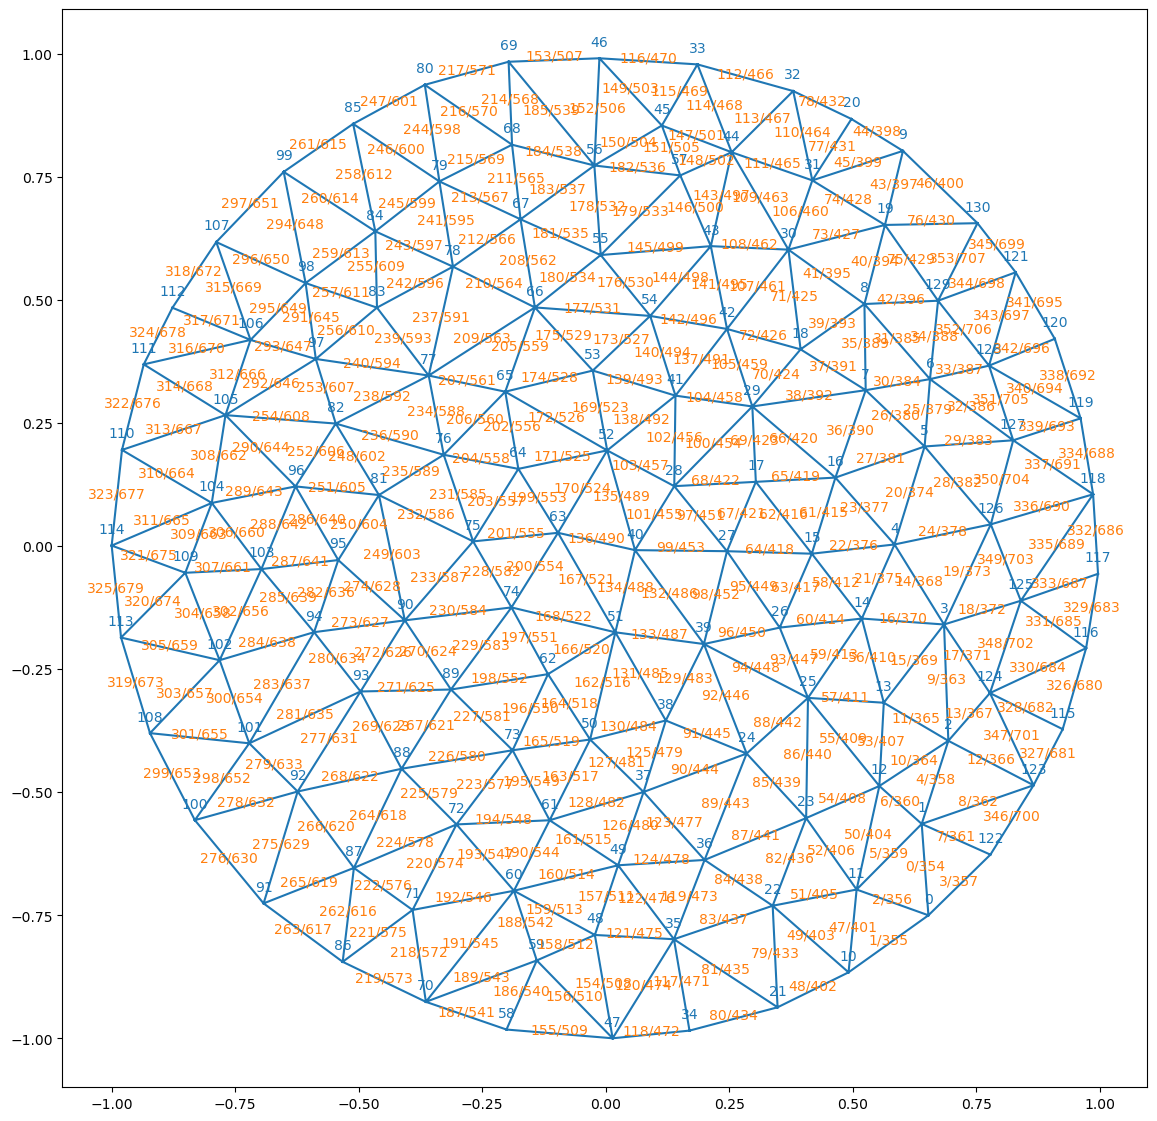

In [30]:
fig = plt.figure(figsize=(14,14))

plt.triplot(*mesh.vertices.T, hemesh.faces)
label_plot(mesh.vertices, hemesh.faces, fontsize=10, hemesh=hemesh, face_labels=False)
plt.axis("equal")

In [31]:
#| notest

# here is how you would do mesh traversal with jax.lax. The issues is that the output size needs to be fixed
# ahead of time, so 

self = hemesh
max_valence = 10
v = 10

initial = jnp.hstack([jnp.array([self.incident[v]]), -1*jnp.ones(max_valence-1, dtype=int)])
jax.lax.fori_loop(1, max_valence, lambda i, x: x.at[i].set(self.twin[x[i-1]]), initial)

Array([ 47, 401,  47, 401,  47, 401,  47, 401,  47, 401], dtype=int64)

### Boundary and the vertex at infinity

So far, our mesh representations `TriMesh` and `HeMesh` work for triangular meshes with and without boundary. Boundary half-edges are assigned to a fictitious `-1` face. This convention has a downside. It is not possible to modify the boundary loop of the mesh by edge flips - doing so would result in an invalid state. In a simulation, this artificially limits the mesh's ability to deform. Instead, we can add "vertices at infinity" and connect al edges in a given boundary to $\infty$. This turns the mesh into a topological sphere. Now, one can flip boundary edges without the overall number of half-edges changing (so the array shape stays the same). 
 Multiple boundaries are also supported. Each boundary corresponds to a distinct $\infty$-vertex (for example, 2 for a cylinder)/

The coordinates of the fictitious vertices are set to `[np.inf, np.inf]` by convention. The boundary is found by iterating around $\infty$.
By convention, $\infty$-vertices, if they exists, are the final vertices of the mesh (don't rely on this - implementation detail). 

We generally assume that the mesh has only a single connected component.

The `HeMesh` class can deal with both the -1-face and the $\infty$-vertices conventions. The latter are listed in the `inf_vertices` attribute of a `HeMesh`.

In [32]:
#| export

def connect_boundary_to_infinity(vertices: Float[jax.Array, "n_vertices 2"],
                                 faces: Int[jax.Array, "n_faces 3"]
                                ) -> tuple[Float[jax.Array, "n_vertices_new 2"],
                                           Int[jax.Array, "n_faces_new 3"],
                                           tuple[int]]:
    """
    Connect boundary loop(s) to infinity.
    
    New vertices are appeneded to the end of vertex array and have coordinates [np.inf, np.inf].

    Parameters 
    ----------
    vertices : Float[jax.Array, "n_vertices 2"]
        Vertex positions.
    faces : Int[jax.Array, "n_faces 2"]
        Faces (triangles) as list of vertex indices.

    Returns
    -------
    new_vertices : Float[jax.Array, "n_vertices_new 2"]
        Vertex positions with infinity vertices appended.
        One infinity vertex per boundary loop.
    new_faces : Int[jax.Array, "n_faces_new 2"]
        Faces (triangles) as list of vertex indices, with new faces added to connect
        boundary loops to infinity vertices.
    inf_vertices : tuple[Int]
        Indices of infinity vertices in new_vertices.
        Will be (n_vertices, n_vertices+1, ..., n_vertices+n_boundaries-1).
    """
    boundary_loops = igl.boundary_loop_all(mesh.faces)
    new_vertices = jnp.copy(vertices)
    new_faces = jnp.copy(faces)

    for loop in boundary_loops:
        inf_index = vertices.shape[0]
        inf_faces = np.stack([[inf_index, v2, v1] for v1, v2 in zip(loop, np.roll(loop, -1))])
        new_vertices = jnp.vstack([new_vertices, jnp.inf*jnp.ones_like(new_vertices[:1])])
        new_faces = jnp.vstack([faces, inf_faces])
    
    return new_vertices, new_faces, tuple(range(vertices.shape[0], new_vertices.shape[0]))

In [33]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)

  o flat_tri_ecmc


In [34]:
new_vertices, new_faces, infinity_vertices = connect_boundary_to_infinity(mesh.vertices, mesh.faces)
mesh_infty = TriMesh(vertices=new_vertices, faces=new_faces)
hemesh_infty = HeMesh.from_triangles(mesh_infty.vertices.shape[0], mesh_infty.faces,
                                     inf_vertices=infinity_vertices)

In [35]:
igl.is_edge_manifold(mesh_infty.faces)[0], igl.is_vertex_manifold(mesh_infty.faces)[0]

(True, np.True_)

In [36]:
hemesh_infty.dest[hemesh_infty.iterate_around_vertex(-1)], igl.boundary_loop(mesh.faces)

(Array([  0,  10,  21,  34,  47,  58,  70,  86,  91, 100, 108, 113, 114,
        110, 111, 112, 107,  99,  85,  80,  69,  46,  33,  32,  20,   9,
        130, 121, 120, 119, 118, 117, 116, 115, 123, 122], dtype=int64),
 array([  0, 122, 123, 115, 116, 117, 118, 119, 120, 121, 130,   9,  20,
         32,  33,  46,  69,  80,  85,  99, 107, 112, 111, 110, 114, 113,
        108, 100,  91,  86,  70,  58,  47,  34,  21,  10], dtype=int64))

In [37]:
hemesh_infty.dest[hemesh_infty.iterate_around_vertex(0)], hemesh.dest[hemesh.iterate_around_vertex(0)]

(Array([  1,  11,  10, 131, 122], dtype=int64),
 Array([  1,  11,  10, 122], dtype=int64))

In [38]:
(hemesh.is_bdry == (hemesh_infty.is_bdry[:-1] >0)).all()

Array(True, dtype=bool)

In [39]:
# to get back the original faces/vertices, do this:

_ = hemesh_infty.faces[~hemesh_infty.is_inf_face]

## Mesh geometry and per-mesh variables

Mesh geometry (vertex and face positions) and per-mesh-item (per-face, per-half-edge, per-vertex) variables are combined into a second data class, the `GeomMesh`.

### Vertex, half-edge, and face properties

In simulations, we will often want to attach extra information to a mesh's vertices/edges/faces. In the `GeomMesh` class, these are saved in three dictionaries, `vertex_attribs`, `he_attribs`, `face_attribs`. Each key/value pair represents one property (for example, the cell target area). All values are arrays, and the first axis corresponds to the number of vertices/half-edges/faces, respectively.
To keep track of the possible attributes, we use `IntEnum`'s as keys (this also ensures keys are hashable, as required by JAX)

In [40]:
#| export

# this is how you set up an enum. It is important to use IntEnum, so we can _order_ the enums.
# The precise Enum you will use depends on your application.

class VertexAttribs(IntEnum):
    TARGET_AREA = 1
    TARGET_PERIMETER = 2

class HeAttribs(IntEnum):
    EDGE_TENSION = 1

class FaceAttribs(IntEnum):
    FACE_AREA = 1

# you can iterate over enums, and they are hashable. The latter is essential for JAX!

[a for a in VertexAttribs], hash(VertexAttribs.TARGET_PERIMETER)

([<VertexAttribs.TARGET_AREA: 1>, <VertexAttribs.TARGET_PERIMETER: 2>], 2)

In [41]:
HeAttribs.EDGE_TENSION, HeAttribs(1), HeAttribs['EDGE_TENSION'], HeAttribs.EDGE_TENSION.name

(<HeAttribs.EDGE_TENSION: 1>,
 <HeAttribs.EDGE_TENSION: 1>,
 <HeAttribs.EDGE_TENSION: 1>,
 'EDGE_TENSION')

In [42]:
#| export

@jax.tree_util.register_dataclass
@dataclasses.dataclass(repr=False, eq=False, frozen=True,)
class GeomMesh:
    """
    Data class for holding mesh geometry and mesh-associated variables.
    To be combined with a HeMesh to specify the connectivity.

    One array (for vertex positions) must always be present. A second,
    but optional, standard entry is a set of positions for each face. 
    The mesh coordinates can live in 2d or 3d.
    
    Optionally, vertices, half-edges, and faces can have attributes (stored as dictionaries).
    The keys of the dictionary should be taken from a suitable 'enum'. The values are 
    ndarrays, whose 0th axis is (vertices/edges/faces). These attribute dicts are
    initialized empty and can be set afterwards.

    See documentation on HeMesh
    
    **Attributes**

    vertices : Float[jax.Array, "n_vertices 2"]

    face_positions : Float[jax.Array, "n_faces 2"]

    vertex_attribs : dict[IntEnum, Float[jax.Array, "n_vertices *"]]

    he_attribs : dict[IntEnum, Float[jax.Array, "n_hes *"]]

    face_attribs : dict[IntEnum, Float[jax.Array, "n_faces *"]]
    
    **Property methods (use like attributes)**

    n_items : tuple[int, int, int]

    dim : int

    **Class methods**

    validate_dimensions : bool

    **Static methods**
    
    load : str -> GeomHeMesh

    """

    n_vertices : int = dataclasses.field(metadata=dict(static=True))
    n_hes : int = dataclasses.field(metadata=dict(static=True))
    n_faces : int = dataclasses.field(metadata=dict(static=True))
    vertices : Float[jax.Array, "*batch n_vertices dim"]
    face_positions : Float[jax.Array, "*batch n_faces 2"] = dataclasses.field(default_factory=lambda : jnp.array([]))
    vertex_attribs : dict[IntEnum, Float[jax.Array, "... n_vertices"]] = dataclasses.field(default_factory=dict)
    he_attribs : dict[IntEnum, Float[jax.Array, "... n_hes"]] = dataclasses.field(default_factory=dict)
    face_attribs : dict[IntEnum, Float[jax.Array, "... n_faces"]] = dataclasses.field(default_factory=dict)
    
    @property
    def n_items(self) -> tuple[int, int, int]:
        return (self.n_vertices, self.n_hes, self.n_faces)

    @property
    def dim(self) -> int:
        return self.vertices.shape[-1]
    
    def __repr__(self) -> str:
        return "GeomMesh(D={},N_V={}, N_HE={}, N_F={})".format(*((self.dim,)+self.n_items))

    def validate_dimensions(self) -> None:
        """Validate input dimensions"""
        if (self.n_vertices != self.vertices.shape[0]):
            raise ValueError("Number of vertices inconsistent")
        if (self.face_positions.shape[0] not in [0, self.n_faces]):
            raise ValueError("Number of faces inconsistent")
        if any([val.shape[0] != self.n_vertices for _, val in self.vertex_attribs.items()]):
            raise ValueError("Vertex property dimension inconsistent")
        if any([val.shape[0] != self.n_hes for _, val in self.he_attribs.items()]):
            raise ValueError("Half-edge property dimension inconsistent")
        if any([val.shape[0] != self.n_faces for _, val in self.face_attribs.items()]):
            raise ValueError("Face property dimension inconsistent")
        return None

    def check_compatibility(self, hemesh: HeMesh) -> bool:
        return self.n_items==hemesh.n_items
    
    ## copying, loading, and saving
    
    def __copy__(self):
        return GeomMesh(*self.n_items, vertices=self.vertices, face_positions=self.face_positions,
                   vertex_attribs={key: jnp.copy(val) for key, val in self.vertex_attribs.items()},
                   he_attribs={key: jnp.copy(val) for key, val in self.he_attribs.items()},
                   face_attribs={key: jnp.copy(val) for key, val in self.face_attribs.items()})

    def save(self, file: str | Path) -> None:
        """Save HeMesh and all geometric attributes to two .npz archives of jnp.arrays"""
        np.savez(file,
             n_vertices=self.n_vertices, n_hes=self.n_hes, n_faces=self.n_faces,
             vertices=self.vertices, face_positions = self.face_positions,
             **{f"VertexAttribs.{key.name}": val for key, val in self.vertex_attribs.items()},
             **{f"HeAttribs.{key.name}": val for key, val in self.he_attribs.items()},
             **{f"FaceAttribs.{key.name}": val for key, val in self.face_attribs.items()},
             allow_pickle=False)
        return None

    @staticmethod
    def load(file: str | Path) -> "GeomMesh":
        """Note: must have the correct Enum's for the vertex/he/face properties imported."""
        npzfile = jnp.load(file)
        vertex_attribs = {VertexAttribs[key.split(".")[1]]: val
                          for key, val  in npzfile.items() if key.split(".")[0] == "VertexAttribs"}
        he_attribs = {HeAttribs[key.split(".")[1]]: val
                      for key, val  in npzfile.items() if key.split(".")[0] == "HeAttribs"}
        face_attribs = {FaceAttribs[key.split(".")[1]]: val
                        for key, val  in npzfile.items() if key.split(".")[0] == "FaceAttribs"}
        return GeomMesh(n_vertices=npzfile['n_vertices'].item(),
                        n_hes=npzfile['n_hes'].item(),
                        n_faces=npzfile['n_faces'].item(),
                        vertices=npzfile['vertices'],
                        face_positions=npzfile['face_positions'],
                        vertex_attribs=vertex_attribs,
                        he_attribs=he_attribs,
                        face_attribs=face_attribs)

    # equality comparisons. Two meshes are equal if all of the arrays they contain are equal.
    
    def __eq__(self, other: Any) -> bool:
        if not isinstance(other, GeomMesh):
            return False          
        if not self.n_items==other.n_items:
            return False
        return jax.tree_util.tree_all(jax.tree.map(jnp.allclose, jax.tree_util.tree_flatten(self)[0],
                                                                 jax.tree_util.tree_flatten(other)[0]))

In [ ]:
#| export

def get_voronoi_face_positions(vertices: Float[jax.Array, "n_vertices 2"], hemesh: HeMesh
                               ) -> Float[jax.Array, "n_faces 2"]:
    """Get face positions of geommesh to the circumcenters of the faces defined by hemesh."""
    face_positions = jax.vmap(trig.get_circumcenter)(*vertices[hemesh.faces].transpose((1,0,2)))
    return face_positions

def set_voronoi_face_positions(geommesh: GeomMesh, hemesh: HeMesh) -> GeomMesh:
    """Set face positions of geommesh to the circumcenters of the faces defined by hemesh."""
    face_positions = get_voronoi_face_positions(geommesh.vertices, hemesh)
    return dataclasses.replace(geommesh, face_positions=face_positions)

In [44]:
#| export

class Mesh(NamedTuple):
    """Combine geometric and connectivity info into a single object."""
    geommesh: GeomMesh
    hemesh: HeMesh

In [45]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

  o flat_tri_ecmc


In [46]:
combined_mesh = Mesh(geommesh, hemesh)
combined_mesh

Mesh(geommesh=GeomMesh(D=2,N_V=131, N_HE=708, N_F=224), hemesh=HeMesh(N_V=131, N_HE=708, N_F=224))

In [47]:
leafs, ts = jax.tree_util.tree_flatten(geommesh) # also a pytree
ts

PyTreeDef(CustomNode(GeomMesh[(131, 708, 224)], [*, *, {}, {}, {}]))

In [48]:
geommesh, geommesh.n_vertices, geommesh.vertices.shape, geommesh.check_compatibility(hemesh), geommesh == geommesh

(GeomMesh(D=2,N_V=131, N_HE=708, N_F=224), 131, (131, 2), True, True)

In [49]:
#| export

def cellplot(hemesh: HeMesh, face_positions: Float[jax.Array, "n_faces 2"],
             cell_colors: None | str | Float[np.ndarray, "4"] | Float[np.ndarray, "n_vertices 4"] =None,
             mpl_polygon_kwargs: None | dict[str, Any] = None) -> mpl.collections.PatchCollection:
    """
    Plot a cell tesselation.
    
    cell_colors can be either a single color (for all cells) or a vector of rgba values.
    Only interior cells are plotted.
    """
    if mpl_polygon_kwargs is None:
        mpl_polygon_kwargs = {"lw": 1, "ec": "k"}
    # formatting for the cell colors - make into a list
    if cell_colors is None:
        cell_colors = np.zeros((hemesh.n_vertices, 4))
    if isinstance(cell_colors, str):
        cell_colors = [cell_colors for v in range(hemesh.n_vertices)]
    if isinstance(cell_colors, Iterable):
        assert len(cell_colors) in [4, hemesh.n_vertices], "Cell color must be 1 or n_vertices rgba values"
        if len(cell_colors) == 4:
            cell_colors = [cell_colors for v in range(hemesh.n_vertices)]
    # iterate over non-boundary vertices.
    polygons = []
    bdry = hemesh.is_bdry
    for v in range(hemesh.n_vertices):
        if not bdry[v]:
            polygon_edges = hemesh.iterate_around_vertex(v)
            polygon_vertices = face_positions[hemesh.heface[np.array(polygon_edges)]]
            polygons.append(mpl.patches.Polygon(polygon_vertices, color=cell_colors[v], **mpl_polygon_kwargs))
    return mpl.collections.PatchCollection(polygons, match_original=True)

(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

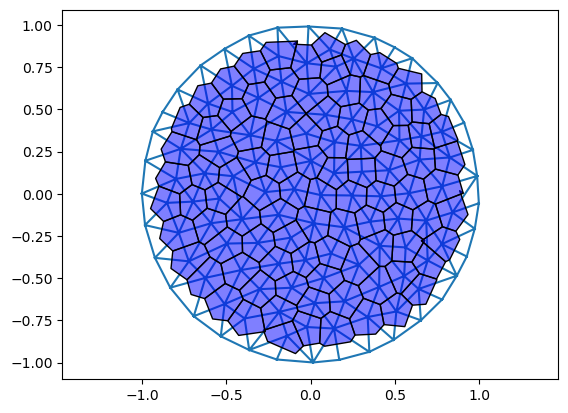

In [50]:
plt.triplot(*geommesh.vertices.T, hemesh.faces)
polygons = cellplot(hemesh, geommesh.face_positions,
                    cell_colors=np.array([0,0,1,0.5]), mpl_polygon_kwargs={"lw": 1, "ec": "k"})
ax = plt.gca()
ax.add_collection(polygons)

plt.axis("equal")


### Adding some vertex/half-edge/face properties

In [51]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommmesh = GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

  o flat_tri_ecmc


In [52]:
# at initialization, a HeMesh's attribute dictionaries are empty
geommmesh.vertex_attribs

{}

In [53]:
# set some attributes

key1 = jax.random.key(0)
_, key2 = jax.random.split(key1)
_, key3 = jax.random.split(key2)

geommmesh = dataclasses.replace(geommmesh, vertex_attribs={VertexAttribs.TARGET_AREA: jax.random.normal(key=key1, shape=geommmesh.n_vertices),
                                                           VertexAttribs.TARGET_PERIMETER: jax.random.normal(key=key2, shape=geommmesh.n_vertices)})
geommmesh = dataclasses.replace(geommmesh, he_attribs={HeAttribs.EDGE_TENSION: jax.random.normal(key=key3, shape=geommmesh.n_hes)})

In [54]:
geommmesh.he_attribs.keys()

dict_keys([<HeAttribs.EDGE_TENSION: 1>])

## Batching

In our simulations, we may want to "batch" over several initial conditions/random seeds/etc (analogous to batching over training data in normal ML). In JAX, we can efficiently and concisely vectorize operations over such "batch axes" with `jax.vmap`. 

To batch over our custom data structures, we need to pull a small trick - convert a list of `HeMesh`/`GeomMeshe` instances into a single mesh with a batch axis for the various arrays. Luckily, this can be [done using JAX's pytree tools](https://stackoverflow.com/questions/79123001/storing-and-jax-vmap-over-pytrees).

In [55]:
#| export

def tree_stack(xs : list[PyTree], axis=0) -> PyTree:
    """Stack a sequence of identical-structure pytrees along a new axis."""
    return jax.tree.map(lambda *leaves: jnp.stack(leaves, axis=axis), *xs)

def tree_unstack(xb: PyTree, axis=0) -> list[PyTree]:
    """Unstack a batched pytree along axis into a list of pytrees."""
    leaves, treedef = jax.tree.flatten(xb)
    B = leaves[0].shape[axis]
    # split every leaf along batch dimension
    per = [jax.tree.unflatten(treedef, [leaf.take(indices=i, axis=axis)  for leaf in leaves])
           for i in range(B)]
    return per

In [56]:
## Let us create a bunch of meshes with different initial positions and see if we can batch over them using vmap

key = jax.random.key(0)
sigma = 0.02

batch_geom = []
batch_he = []
for i in range(3):
    key, subkey = jax.random.split(key)
    random_noise = jax.random.normal(subkey, shape=geommmesh.vertices.shape)
    batch_geom.append(dataclasses.replace(geommmesh, vertices=geommmesh.vertices+sigma*random_noise))
    batch_he.append(copy.copy(hemesh))

In [57]:
# define a test function to appy over the batch

def test_function(geommesh: GeomMesh, hemesh: HeMesh) -> Float[jax.Array, " n_vertices"]:
    """Dummy test function."""
    return jnp.ones(geommesh.n_vertices)

In [58]:
#| notest

# naive batching does not work. JAX needs a "struct-of-arrays", but a list of HeMeshes is an "array-of-structs"
# see https://stackoverflow.com/questions/79123001/storing-and-jax-vmap-over-pytrees

try:
    jax.vmap(test_function)(batch_geom, batch_he)
except (ValueError, TypeError) as e:
    print("Expected error:", e)

Expected error: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (21 of them) had size 708, e.g. axis 0 of argument geommesh[0].he_attribs[<HeAttribs.EDGE_TENSION: 1>] of type float64[708];
  * some axes (12 of them) had size 131, e.g. axis 0 of argument geommesh[0].vertices of type float64[131,2];
  * some axes (6 of them) had size 224, e.g. axis 0 of argument geommesh[0].face_positions of type float64[224,2]


In [59]:
# instead, we use a jax.tree.map to "push" the list axis into the underlying arrays.

batch_he_array = tree_stack(batch_he)
batch_geom_array = tree_stack(batch_geom)
batch_geom_array, batch_geom_array.vertices.shape

(GeomMesh(D=2,N_V=131, N_HE=708, N_F=224), (3, 131, 2))

In [60]:
%unload_ext jaxtyping

The jaxtyping extension is not loaded.


In [61]:
# now it works! The result is a single object with batch axis

batch_out = jax.vmap(test_function)(batch_geom_array, batch_he_array) 
batch_out.shape

(3, 131)

In [62]:
# we can unpack things again into a list of meshes

isinstance(tree_unstack(batch_out), list)

True

## Edge flips / T1s

In our simulations, cells will exchange neighbors (T1-event). In the triangulation, this corresponds to an edge flip. We now implement the edge flip algorithm for `HeMesh`es. We basically edit the various connectivity arrays (in a JAX-compatible way).

The algorithm (and the naming conventions in `flip_edge`) are from here: https://jerryyin.info/geometry-processing-algorithms/half-edge/.

**Before**

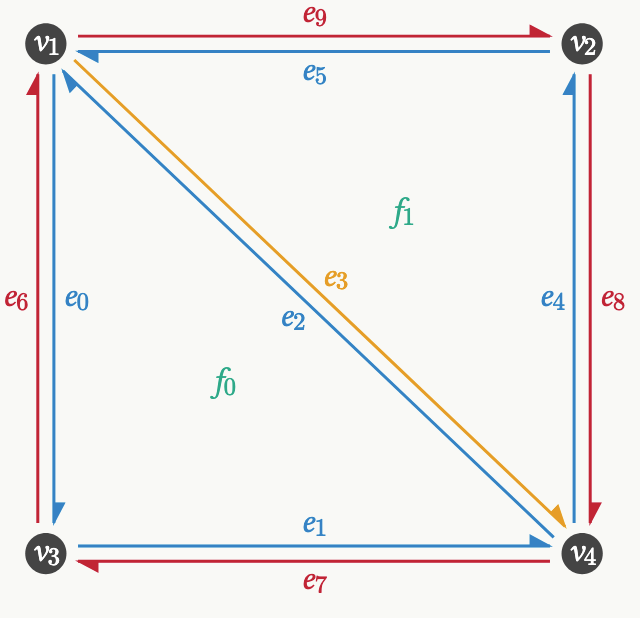

**After**

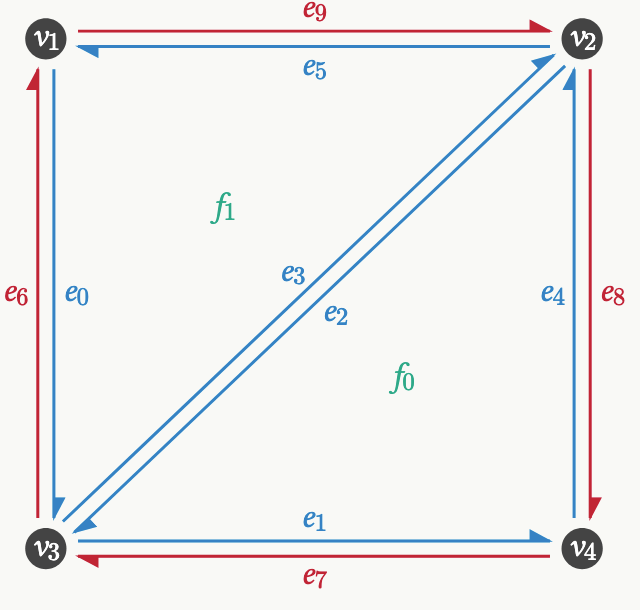

In [63]:
#| export

@functools.partial(jax.jit, static_argnames=['check_boundary'])
def flip_edge(hemesh: HeMesh, e: Int[jax.Array, ""], check_boundary: bool = False) -> HeMesh:
    """
    Flip half-edge e in a half-edge mesh.
    
    See https://jerryyin.info/geometry-processing-algorithms/half-edge/. The algorithm
    is slightly modified since we keep track of the origin and destination of a half-edge,
    and use arrays instead of pointers. Returns a new HeMesh, does not modify in-place.
    """
    if check_boundary:
        assert (hemesh.heface[e] !=-1 and hemesh.heface[hemesh.twin[e]] != -1), "Cannot flip boundary edge"

    # identify relevant elements
    e5 = hemesh.prv[e]
    e4 = hemesh.nxt[e]
    twin = hemesh.twin[e]
    e1 = hemesh.prv[twin] 
    e0 = hemesh.nxt[twin] 

    # make sure there’s no vertex or face references to e or twin
    incident = hemesh.incident.at[jnp.array([hemesh.orig[e], hemesh.orig[twin]])].set(
        jnp.array([hemesh.twin[e5], hemesh.twin[e1]]))
    face_incident = hemesh.face_incident.at[jnp.array([hemesh.heface[e], hemesh.heface[twin]])].set(
        jnp.array([e5, e1])) # e1, e5 don't change face

    # update the data structure to do the T1
    nxt = hemesh.nxt.at[jnp.array([e, twin])].set(jnp.array([e5, e1]))
    prv = hemesh.prv.at[jnp.array([e, twin])].set(jnp.array([e0, e4]))
    orig = hemesh.orig.at[jnp.array([e, twin])].set(jnp.array([hemesh.orig[e1], hemesh.orig[e5]]) )
    dest = hemesh.dest.at[jnp.array([e, twin])].set(jnp.array([hemesh.dest[e4], hemesh.dest[e0]]))

    nxt = nxt.at[jnp.array([e0, e1, e4, e5])].set(jnp.array([e, e4, twin, e0]) )
    prv = prv.at[jnp.array([e0, e1, e4, e5])].set(jnp.array([e5, twin, e1, e]) )
    heface = hemesh.heface.at[jnp.array([e0, e4])].set(jnp.array([hemesh.heface[e5], hemesh.heface[e1]]))

    return HeMesh(incident, orig, dest, jnp.copy(hemesh.twin), nxt, prv, heface, face_incident, hemesh.inf_vertices)

In [ ]:
#| export

def get_signed_dual_he_length(vertices: Float[jax.Array, "n_vertices 2"],
                              face_positions: Float[jax.Array, "n_hes 2"],
                              hemesh: HeMesh) -> Float[jax.Array, " n_hes"]:
    """Compute lengths of dual edges. Boundary dual edges get length jnp.nan. Negative sign = flipped edge."""
    edges = vertices[hemesh.orig]-vertices[hemesh.dest]
    dual_edges = face_positions[hemesh.heface]-face_positions[hemesh.heface[hemesh.twin]]
    signed_squared_length = jnp.einsum('vi,vi->v', edges, dual_edges @ trig.get_rot_mat(np.pi/2))
    signed_length = jnp.sign(signed_squared_length) * jnp.sqrt(jnp.abs(signed_squared_length))
    signed_length = jnp.where(hemesh.is_bdry_edge, jnp.nan, signed_length)
    return signed_length

In [65]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

  o flat_tri_ecmc


(np.float64(-1.10003475),
 np.float64(1.09628575),
 np.float64(-1.09934025),
 np.float64(1.09050125))

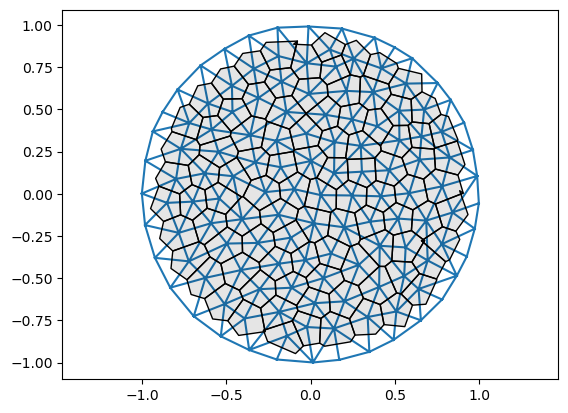

In [66]:
plt.triplot(*geommesh.vertices.T, hemesh.faces)
ax = plt.gca()
p = cellplot(hemesh, geommesh.face_positions,
             cell_colors=np.array([0,0,0,0.1]), mpl_polygon_kwargs={"lw": 1, "ec": "k"})
plt.gca().add_collection(p)

plt.axis("equal")

In [67]:
# edges and dual edges should be orthogonal since we are using circumcenters

edges = geommesh.vertices[hemesh.orig]-geommesh.vertices[hemesh.dest]
dual_edges = (geommesh.face_positions[hemesh.heface]
              -geommesh.face_positions[hemesh.heface[hemesh.twin]])

jnp.allclose(jnp.einsum('vi,vi->v', edges[~hemesh.is_bdry_edge], dual_edges[~hemesh.is_bdry_edge]), 0)

Array(True, dtype=bool)

In [ ]:
# computing the signed edge length shows that there are some "flipped" edges.

signed_squared_length = jnp.einsum('vi,vi->v', edges, dual_edges @ trig.get_rot_mat(np.pi/2))
jnp.where((signed_squared_length < -0.0) & ~hemesh.is_bdry_edge )[0]

Array([  9, 185, 191, 335, 363, 539, 545, 689], dtype=int64)

In [69]:
isinstance(335, int)

True

In [70]:
# flip edge and recompute face positions

flipped_hemesh = flip_edge(hemesh, e=335)
flipped_geommesh = set_voronoi_face_positions(geommesh, flipped_hemesh)

In [71]:
# connectivity is still valid

igl.is_edge_manifold(hemesh.faces)[0], igl.is_edge_manifold(flipped_hemesh.faces)[0], flipped_hemesh.iterate_around_vertex(100)

(True, True, Array([298, 299, 630, 632], dtype=int64))

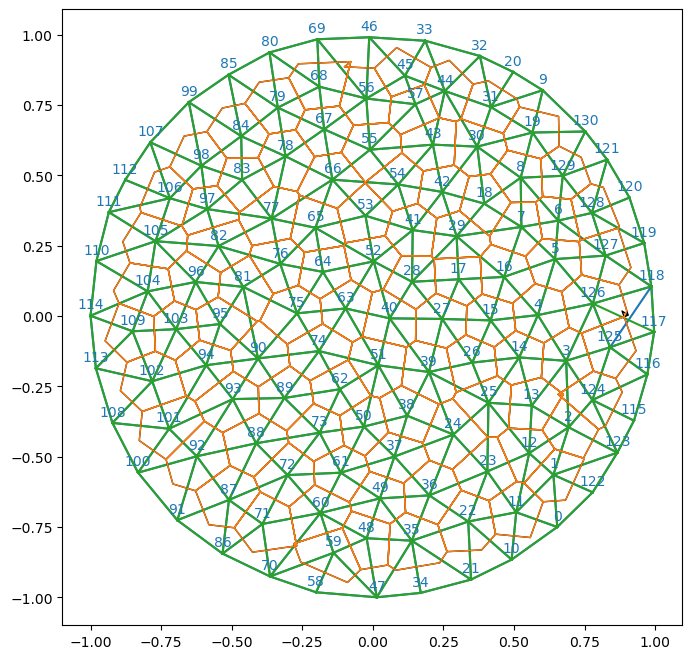

In [72]:
# you can see the flipped edge in the plot below - it's where the blue mesh forms a "bow-tie"

fig = plt.figure(figsize=(8,8))

plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*flipped_geommesh.vertices.T, flipped_hemesh.faces)

ax = plt.gca()
p1 = cellplot(hemesh, geommesh.face_positions,
         cell_colors=np.array([0.,0.,0.,0.]), mpl_polygon_kwargs={"lw": 1, "ec": "k"})
p2 = cellplot(flipped_hemesh, flipped_geommesh.face_positions,
              cell_colors=np.array([0.,0.,0.,0.]), mpl_polygon_kwargs={"lw": 1, "ec": "tab:orange"})
ax.add_collection(p1)
ax.add_collection(p2)
plt.axis("equal")

label_plot(geommesh.vertices, hemesh.faces, fontsize=10, face_labels=False)

#### Repeated flips

In a simulation, we need to carry out edge flips at every timestep. The function `flip_edge(hemesh: HeMesh, e: int) -> HeMesh` does a single edge flip by modifying the connectivity arrays. Luckily, it is already JAX-compatible (we can JIT-compile it).

The next goal is to carry out multiple flips. We must be careful: doing multiple flips "simultaneously" risks leaving the mesh in an inconsistent state.
Instead, we do the flips in sequence. To make things JAX-compatible, we do a `jax.lax.scan` scan over all half-edges.

In [73]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

  o flat_tri_ecmc


In [ ]:
dual_lengths = get_signed_dual_he_length(geommesh.vertices, geommesh.face_positions, hemesh)
edges = jnp.where((dual_lengths < -0.05) & ~hemesh.is_bdry_edge & hemesh.is_unique)[0]
# we only want to flip unique hes!
edges, edges.size

(Array([  9, 185, 191, 335], dtype=int64), 4)

In [75]:
# scan over indices of negative-length edges. 
flipped_hemesh, _ = jax.lax.scan(lambda h, e: (flip_edge(h, e), None) , init=hemesh, xs=edges)

# this scan is over an array whose shape varies. Instead, we can scan over all hes, and flip only if the length is negative (via jax.lax.cond).

In [76]:
#| export

@jax.jit
def flip_all(hemesh: HeMesh, to_flip: Bool[jax.Array, " n_hes"]) -> HeMesh:
    """Flip all (unique) half-edges where to_flip is True in a half-edge mesh. Wraps flip_edge."""
    def scan_fun(h, e): # flips edge e if its length < 0 and edge is unique. Otherwise, you undo your flips!
        return jax.lax.cond(to_flip[e] & hemesh.is_unique[e],
                            lambda hh: flip_edge(hh, e), lambda hh: hh, h), None
    flipped_hemesh, _ = jax.lax.scan(scan_fun, init=hemesh, xs=jnp.arange(hemesh.n_hes) )
    return flipped_hemesh

In [77]:
to_flip = (dual_lengths < 0) & ~jnp.isnan(dual_lengths)

flipped_hemesh = flip_all(hemesh, to_flip=to_flip)

In [78]:
flipped_hemesh = flip_all(hemesh, to_flip=(dual_lengths<0.02)) # no extra recompile

In [79]:
flipped_geommesh = set_voronoi_face_positions(geommesh, flipped_hemesh)

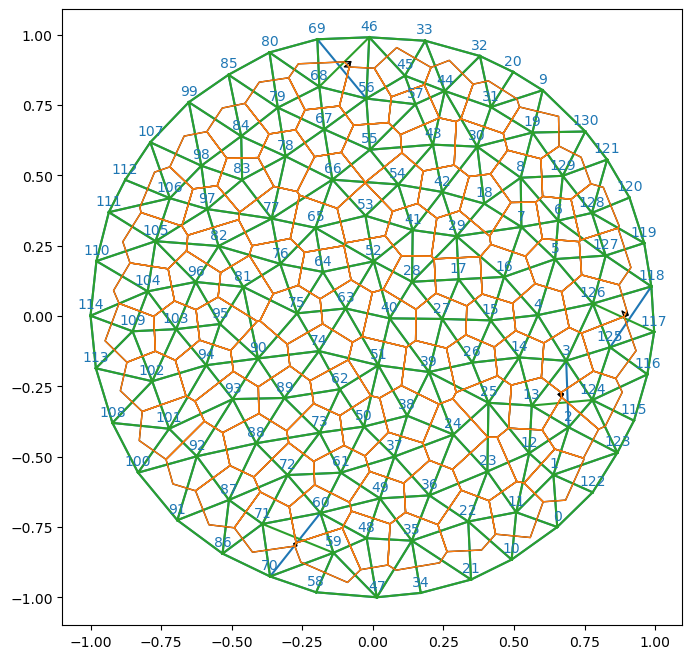

In [80]:
fig = plt.figure(figsize=(8,8))

plt.triplot(*geommesh.vertices.T, hemesh.faces)
plt.triplot(*flipped_geommesh.vertices.T, flipped_hemesh.faces)

ax = plt.gca()
ax = plt.gca()
p1 = cellplot(hemesh, geommesh.face_positions,
         cell_colors=np.array([0.,0.,0.,0.]), mpl_polygon_kwargs={"lw": 1, "ec": "k"})
p2 = cellplot(flipped_hemesh, flipped_geommesh.face_positions,
              cell_colors=np.array([0.,0.,0.,0.]), mpl_polygon_kwargs={"lw": 1, "ec": "tab:orange"})
ax.add_collection(p1)
ax.add_collection(p2)
plt.axis("equal")

label_plot(geommesh.vertices, hemesh.faces, fontsize=10, face_labels=False)

## Adjacency-like operators on half-edge meshes

### Computing cell areas, perimeters, etc via corners

To compute, for instance, the cell area using the shoelace formula, you need to iterate around the faces adjacent to a vertex. This is not straightforward to vectorize because the number of adjacent faces per vertex can vary (there can be 5-, 6-, 7-sided cells etc.).
That is, the list of adjacent faces is a "ragged" array. However, vectorization is essential for numerical efficiency and compatibility with JAX. For example, we may want to compute an energy and its gradient, which depends on cell areas.
One way to solve this is a scheme in which the lists of adjacent faces are "padded" in some manner, so that they are all the same length. This is cumbersome.

Instead, let us split all "cell-based" quantities into contributions from "corners", i.e., half-edges, like this:

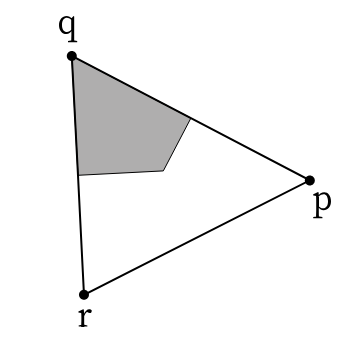
Source: [CGAL](https://doc.cgal.org/latest/Weights/group__PkgWeightsRefVoronoiRegionWeights.html)

To compute the total area, we can sum over all half-edges $(r,p)$ opposite to a vertex $q$.
Numerically, this can be achieved efficiently using gather/scatter operations.

In [81]:
#| export

# gather-scatter operations - sum from half-edges to vertices etc. Many other operations can be done similarly

def sum_he_to_vertex_incoming(hemesh: HeMesh, he_field: Float[jax.Array, "n_hes ..."]):
    """
    Sum a half-edge field onto destination vertices.

    hemesh: connectivity information
    he_field: (n_hes,) or (n_hes, d) array
    """
    out_shape = (hemesh.n_vertices,) + he_field.shape[1:]  # supports scalar or vector fields
    v_field = jnp.zeros(out_shape, dtype=he_field.dtype)
    # Scatter-add: for each half-edge h, add he_field[h] to v_field[dest[h]]
    return v_field.at[hemesh.dest].add(he_field)

def sum_he_to_vertex_opposite(hemesh: HeMesh, he_field: Float[jax.Array, "n_hes ..."]):
    """
    Sum a half-edge field onto opposite vertices.

    hemesh: connectivity information
    he_field: (n_hes,) or (n_hes, d) array
    """
    out_shape = (hemesh.n_vertices,) + he_field.shape[1:]  # supports scalar or vector fields
    v_field = jnp.zeros(out_shape, dtype=he_field.dtype)
    return v_field.at[hemesh.dest[hemesh.nxt]].add(he_field)


In [82]:
# TO DO: implement gradient (vertex -> face) and cotan-Laplacian (vertex -> vertex) using gather/scatter ops like above .
# compare with igl to check correctness. 

In [83]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)
geommesh = GeomMesh(*hemesh.n_items, mesh.vertices, mesh.face_positions)

  o flat_tri_ecmc


In [ ]:
#| export

def get_cell_areas(geommesh: GeomMesh, hemesh: HeMesh) -> Float[jax.Array, " n_vertices"]:
    """
    Compute areas of cells by mesh traversal (don't use for simulation, inefficient).

    Boundary vertices get area 0.
    """
    areas = np.zeros(hemesh.n_vertices)
    bdry = hemesh.is_bdry
    for v in range(hemesh.n_vertices):
        if bdry[v]:
            areas[v] = 0
        else:
            adjacent_faces = hemesh.heface[hemesh.iterate_around_vertex(v)]
            polygon = geommesh.face_positions[adjacent_faces]
            areas[v] = trig.get_polygon_area(polygon)
    return jnp.array(areas)

In [ ]:
## Let's use the adjacency matrix to compute the area of all cells. First, compute all corner areas

a, b, c = (hemesh.dest[hemesh.nxt], hemesh.dest[hemesh.prv], hemesh.dest)

corner_areas = jax.vmap(trig.get_voronoi_corner_area)(geommesh.vertices[a], geommesh.vertices[b], geommesh.vertices[c])
cell_areas_corner = sum_he_to_vertex_opposite(hemesh, corner_areas)
cell_areas_corner = cell_areas_corner.at[hemesh.is_bdry].set(0)

In [86]:
# for comparison, compute the areas by mesh traversal

cell_areas_iterative = -1*get_cell_areas(geommesh, hemesh)
np.abs(cell_areas_iterative-cell_areas_corner).max() # works!

np.float64(4.85722573273506e-17)

In [87]:
# using the gather/scatter trick, we can also compute the coordination number
sum_he_to_vertex_incoming(hemesh, jnp.ones(hemesh.n_hes)).at[hemesh.is_bdry].set(0) 

Array([0., 6., 6., 7., 6., 6., 6., 6., 6., 0., 0., 6., 6., 5., 6., 6., 6.,
       5., 5., 6., 0., 0., 6., 6., 6., 7., 5., 6., 6., 7., 7., 6., 0., 0.,
       0., 7., 6., 6., 5., 7., 6., 6., 6., 6., 7., 5., 0., 0., 5., 6., 6.,
       7., 7., 5., 6., 6., 7., 5., 0., 5., 7., 6., 5., 6., 5., 6., 7., 6.,
       5., 0., 0., 5., 6., 6., 6., 6., 6., 7., 6., 6., 0., 6., 6., 5., 6.,
       0., 0., 6., 6., 6., 7., 0., 6., 6., 6., 5., 6., 6., 6., 0., 0., 6.,
       6., 6., 6., 7., 6., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 6., 6., 6., 6., 6., 6., 0.], dtype=float64)

## Saving to disk


We save and load `TriMesh` meshes as standard `.obj` files (with the hack of using `vn` lines for the face positions). The `HeMesh` class is basically a collection of arrays, which we can save to disk using `numpy`.

In [88]:
from tempfile import TemporaryFile

In [89]:
mesh = TriMesh.read_obj("test_meshes/disk.obj")
hemesh = HeMesh.from_triangles(mesh.vertices.shape[0], mesh.faces)

  o flat_tri_ecmc


In [90]:
# this is how to use np.savenpz

outfile = TemporaryFile()

x = np.arange(10)
y = np.sin(x)

np.savez(outfile, x=x, y=y)
_ = outfile.seek(0) # simulates closing & reopening file

npzfile = np.load(outfile)
sorted(npzfile.files), npzfile['x']

(['x', 'y'], array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [91]:
outfile = TemporaryFile()

hemesh.save(outfile)
_ = outfile.seek(0) # simulates closing & reopening file
npzfile = np.load(outfile)
npzfile.files

['incident',
 'orig',
 'dest',
 'twin',
 'nxt',
 'prv',
 'heface',
 'face_incident',
 'inf_vertices']

In [92]:
outfile = TemporaryFile()

hemesh.save(outfile)
_ = outfile.seek(0) # simulates closing & reopening file
reloaded = HeMesh.load(outfile)

np.allclose(reloaded.faces, hemesh.faces)

True

### Next steps

Looks good - the JAX-compatible triangular-mesh data structures seem to work. In particular, the tricky T1/edge-flip function. 
Next steps: toy simulation, notebook 01. 

